In [2]:
import json
import math
import random
from collections import defaultdict
from itertools import count

import numpy as np
import gymnasium as gym
from gymnasium.spaces import Discrete
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import games

In [7]:
class EpsilonGreedy:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
    
    def select(self, num_envs, states, action_spaces, qfunction):
        mask = np.random.rand(num_envs) < self.epsilon
        mask_inv = np.invert(mask)
        return action_spaces.sample() * mask + qfunction.get_argmax_q(states) * mask_inv


class EpsilonDecreasing:
    def __init__(self, epsilon=1.0, alpha=0.99, lower_bound=0.01):
        self.epsilon_greedy_bandit = EpsilonGreedy(epsilon)
        self.initial_epsilon = epsilon
        self.alpha = alpha
        self.lower_bound = lower_bound

    def reset(self):
        self.epsilon_greedy_bandit = EpsilonGreedy(self.initial_epsilon)

    def select(self, num_envs, states, action_spaces, qfunction):
        results = self.epsilon_greedy_bandit.select(num_envs, states, action_spaces, qfunction)
        self.epsilon_greedy_bandit.epsilon = max(
            self.epsilon_greedy_bandit.epsilon * self.alpha, self.lower_bound
            # self.epsilon_greedy_bandit.epsilon * self.alpha ** num_envs, self.lower_bound
        )
        return results

## DQN (CPU version)

In [3]:
class DeepQFunction(nn.Module):
    def __init__(self, num_states, num_actions, hidden_dim=32, alpha=1e-4):
        super().__init__()
        self.layer1 = nn.Linear(num_states, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, num_actions)
        self.optimiser = optim.AdamW(self.parameters(), lr=alpha, amsgrad=True)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

    def get_q(self, states, actions):
        states_tensor = torch.as_tensor(states, dtype=torch.float32)
        actions_tensor = torch.as_tensor(actions, dtype=torch.int64)
        with torch.no_grad():
            logits = self.forward(states_tensor)
        q_values = logits.gather(-1, actions_tensor.unsqueeze(-1))
        return q_values.squeeze(-1).numpy()
    
    def get_max_q(self, states):
        states_tensor = torch.as_tensor(states, dtype=torch.float32)
        with torch.no_grad():
            logits = self.forward(states_tensor)
        return logits.max(-1).values.numpy()
    
    def get_argmax_q(self, states):
        states_tensor = torch.as_tensor(states, dtype=torch.float32)
        with torch.no_grad():
            logits = self.forward(states_tensor)
        return logits.max(-1).indices.numpy()        
    
    def update(self, states, actions, deltas, non_final_mask):
        states_tensor = torch.as_tensor(states, dtype=torch.float32)
        actions_tensor = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1)
        deltas_tensor = torch.as_tensor(deltas, dtype=torch.float32).unsqueeze(-1)
        non_final_mask = torch.tensor(non_final_mask).unsqueeze(-1)
        q_values = self.forward(states_tensor).gather(-1, actions_tensor)
        loss = F.smooth_l1_loss(
            torch.masked_select(q_values, non_final_mask),
            torch.masked_select(deltas_tensor, non_final_mask)
        )
        self.optimiser.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(self.parameters(), 100)
        self.optimiser.step()
    
    def save(self, filename):
        torch.save(self.state_dict(), filename)
    
    @classmethod
    def load(cls, filename, num_states, num_actions, hidden_dim=32, alpha=1e-4):
        qfunction = cls(num_states, num_actions, hidden_dim, alpha)
        qfunction.load_state_dict(torch.load(filename))
        return qfunction

In [4]:
class QLearning:
    def __init__(self, envs, bandit, qfunction, gamma=1):
        self.envs = envs
        self.bandit = bandit
        self.qfunction = qfunction
        self.gamma = gamma
    
    def execute(self, episodes=2000):
        mean_rewards = []
        for episode in range(episodes):
            # Get initial states and actions.
            observations, infos = self.envs.reset()
            states = np.array(observations).T
            action_spaces = self.envs.action_space
            actions = self.bandit.select(self.envs.num_envs, states, action_spaces, self.qfunction)
            # Run the episode in batched environments.
            episode_rewards = np.zeros(self.envs.num_envs)
            non_final_mask = np.full(self.envs.num_envs, True)
            steps = np.zeros(self.envs.num_envs)
            # If all environment end, break the loop.
            while non_final_mask.any():
                (next_observations, rewards, terminateds, truncateds, infos) = self.envs.step(actions)             
                next_states = np.array(next_observations).T
                next_actions = self.bandit.select(self.envs.num_envs, next_states, action_spaces, self.qfunction)
                deltas = self.get_deltas(states, actions, rewards, next_states, next_actions, terminateds)
                # Update q network by deltas.
                self.qfunction.update(states, actions, deltas, non_final_mask)
                # Update some veriables.
                episode_rewards += rewards * (self.gamma ** steps) * non_final_mask
                non_final_mask = np.logical_and(non_final_mask, np.invert(terminateds + truncateds))
                steps += 1
                states = next_states
                actions = next_actions    
            mean_rewards.append(episode_rewards.mean())
        return mean_rewards
    
    def get_deltas(self, states, actions, rewards, next_states, next_actions, terminateds):
        q_values = self.qfunction.get_q(states, actions)
        next_state_values = self.state_value(next_states) * np.invert(terminateds)
        delta = rewards + self.gamma * next_state_values - q_values
        return delta
    
    def state_value(self, states):
        max_q_value = self.qfunction.get_max_q(states)
        return max_q_value


def get_ema(rewards, smoothing_factor=0.9):
    smoothed_rewards = []
    for reward in rewards:
        if smoothed_rewards == []:
            smoothed_rewards = [reward]
        else:
            smoothed_rewards += [
                smoothed_rewards[-1] * smoothing_factor
                + reward * (1 - smoothing_factor)
            ]
    return smoothed_rewards

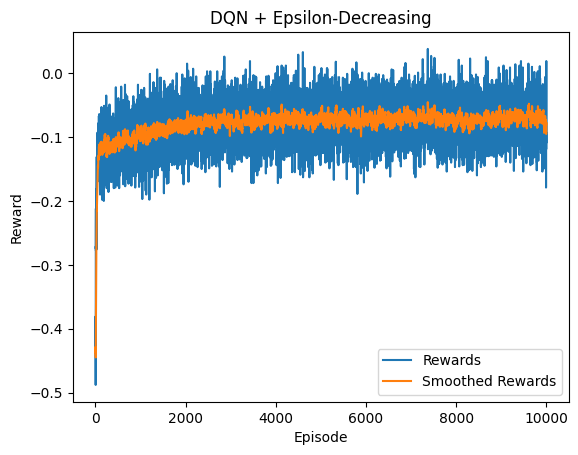

In [5]:
envs = gym.vector.SyncVectorEnv(
    [
    lambda: gym.make('games/Blackjack') for _ in range(1000)
    ]
)
qfunction = DeepQFunction(num_states=3, num_actions=2)
rewards = QLearning(envs, EpsilonDecreasing(), qfunction).execute(episodes=10000)
smoothed_rewards = get_ema(rewards)
qfunction.save(filename='weights_32.pth')

plt.plot(rewards, label='Rewards')
plt.plot(smoothed_rewards, label='Smoothed Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('DQN + Epsilon-Decreasing')
plt.show()

In [30]:
def execute_policy(envs, qfunction):
    observations, infos = envs.reset()
    states = np.array(observations).T
    actions = qfunction.get_argmax_q(states)
    non_final_mask = np.full(envs.num_envs, True)
    results = np.zeros(envs.num_envs)
    while non_final_mask.any():
        (observations, rewards, terminateds, truncateds, infos) = envs.step(actions)
        states = np.array(observations).T
        actions = qfunction.get_argmax_q(states)
        results += rewards * non_final_mask
        non_final_mask = np.logical_and(non_final_mask, np.invert(terminateds + truncateds))
        
    rewards, counts = np.unique(results, return_counts=True)
    for i in range(len(rewards)):
        print(f'P({rewards[i]}) = {counts[i] / envs.num_envs}')
    return results

In [31]:
envs = gym.vector.SyncVectorEnv(
    [
    lambda: gym.make('games/Blackjack') for _ in range(50000)
    ]
)
qfunction32 = DeepQFunction.load('weights_32.pth', num_states=3, num_actions=2)
# qfunction64 = DeepQFunction.load('weights_64.pth', num_states=3, num_actions=2, hidden_dim=64)
# qfunction128 = DeepQFunction.load('weights_128.pth', num_states=3, num_actions=2, hidden_dim=128)
print('dimention=32:')
res1 = execute_policy(envs, qfunction32)
# print('dimention=64:')
# res2 = execute_policy(envs, qfunction64)
# print('dimention=128:')
# res3 = execute_policy(envs, qfunction128)

dimention=32:
P(-1.0) = 0.48678
P(0.0) = 0.09854
P(1.0) = 0.41468
dimention=64:
P(-1.0) = 0.4855
P(0.0) = 0.09438
P(1.0) = 0.42012
dimention=128:
P(-1.0) = 0.48404
P(0.0) = 0.09914
P(1.0) = 0.41682


## DQN (GPU version)

In [4]:
class DeepQFunction(nn.Module):
    def __init__(self, num_states, num_actions, hidden_dim=32, alpha=1e-4, device=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_states, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)
        ).to(device)
        self.optimiser = optim.AdamW(self.parameters(), lr=alpha, amsgrad=True)
        self.device = device

    def forward(self, x):
        return self.net(x)

    def get_q(self, states, actions):
        states_tensor = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        actions_tensor = torch.as_tensor(actions, dtype=torch.int64, device=self.device)
        with torch.no_grad():
            logits = self.forward(states_tensor)
        q_values = logits.gather(-1, actions_tensor.unsqueeze(-1))
        return q_values.squeeze(-1).numpy()
    
    def get_max_q(self, states):
        states_tensor = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            logits = self.forward(states_tensor)
        return logits.max(-1).values.numpy()
    
    def get_argmax_q(self, states):
        states_tensor = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            logits = self.forward(states_tensor)
        return logits.max(-1).indices.numpy()        
    
    def update(self, states, actions, deltas, non_final_mask):
        states_tensor = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        actions_tensor = torch.as_tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(-1)
        deltas_tensor = torch.as_tensor(deltas, dtype=torch.float32, device=self.device).unsqueeze(-1)
        non_final_mask = torch.tensor(non_final_mask, device=self.device).unsqueeze(-1)
        q_values = self.forward(states_tensor).gather(-1, actions_tensor)
        loss = F.smooth_l1_loss(
            torch.masked_select(q_values, non_final_mask),
            torch.masked_select(deltas_tensor, non_final_mask)
        )
        self.optimiser.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(self.parameters(), 100)
        self.optimiser.step()
    
    def save(self, filename):
        torch.save(self.state_dict(), filename)
    
    @classmethod
    def load(cls, filename, num_states, num_actions, hidden_dim=32, alpha=1e-4):
        qfunction = cls(num_states, num_actions, hidden_dim, alpha)
        qfunction.load_state_dict(torch.load(filename))
        return qfunction

In [5]:
class QLearning:
    def __init__(self, envs, bandit, qfunction, gamma=1):
        self.envs = envs
        self.bandit = bandit
        self.qfunction = qfunction
        self.gamma = gamma
    
    def execute(self, episodes=2000):
        mean_rewards = []
        for episode in range(episodes):
            # Get initial states and actions.
            observations, infos = self.envs.reset()
            states = np.array(observations).T
            action_spaces = self.envs.action_space
            actions = self.bandit.select(self.envs.num_envs, states, action_spaces, self.qfunction)
            # Run the episode in batched environments.
            episode_rewards = np.zeros(self.envs.num_envs)
            non_final_mask = np.full(self.envs.num_envs, True)
            steps = np.zeros(self.envs.num_envs)
            # If all environment end, break the loop.
            while non_final_mask.any():
                (next_observations, rewards, terminateds, truncateds, infos) = self.envs.step(actions)             
                next_states = np.array(next_observations).T
                next_actions = self.bandit.select(self.envs.num_envs, next_states, action_spaces, self.qfunction)
                deltas = self.get_deltas(states, actions, rewards, next_states, next_actions, terminateds)
                # Update q network by deltas.
                self.qfunction.update(states, actions, deltas, non_final_mask)
                # Update some veriables.
                episode_rewards += rewards * (self.gamma ** steps) * non_final_mask
                non_final_mask = np.logical_and(non_final_mask, np.invert(terminateds + truncateds))
                steps += 1
                states = next_states
                actions = next_actions    
            mean_rewards.append(episode_rewards.mean())
        return mean_rewards
    
    def get_deltas(self, states, actions, rewards, next_states, next_actions, terminateds):
        q_values = self.qfunction.get_q(states, actions)
        next_state_values = self.state_value(next_states) * np.invert(terminateds)
        delta = rewards + self.gamma * next_state_values - q_values
        return delta
    
    def state_value(self, states):
        max_q_value = self.qfunction.get_max_q(states)
        return max_q_value


def get_ema(rewards, smoothing_factor=0.9):
    smoothed_rewards = []
    for reward in rewards:
        if smoothed_rewards == []:
            smoothed_rewards = [reward]
        else:
            smoothed_rewards += [
                smoothed_rewards[-1] * smoothing_factor
                + reward * (1 - smoothing_factor)
            ]
    return smoothed_rewards

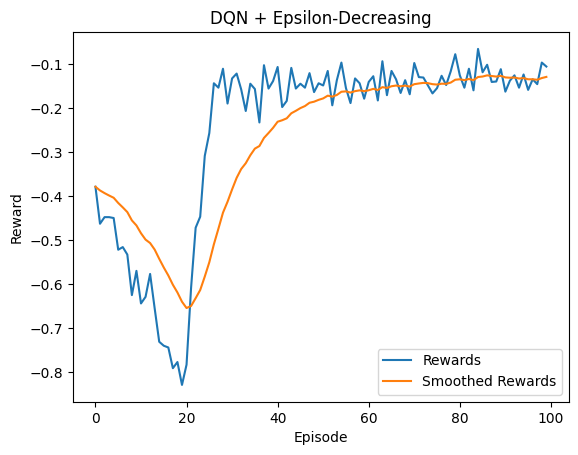

In [12]:
envs = gym.vector.SyncVectorEnv(
    [
    lambda: gym.make('games/Blackjack') for _ in range(1000)
    ]
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
qfunction = DeepQFunction(num_states=3, num_actions=2, device=device)
rewards = QLearning(envs, EpsilonDecreasing(), qfunction).execute(episodes=100)
smoothed_rewards = get_ema(rewards)
qfunction.save(filename='weights_32.pth')

plt.plot(rewards, label='Rewards')
plt.plot(smoothed_rewards, label='Smoothed Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('DQN + Epsilon-Decreasing')
plt.show()